Sistema baseado na rede de distribuição de gás natural

1 Duto

equações :
$$
\frac{\partial}{\partial t}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
=
\begin{bmatrix}
-w & 0 & -T \frac{V^{*} P'_T}{C_V} \\
0 & -w & V \\
- V^{*} P'_T & -V^{*} P'_V & -w
\end{bmatrix}
\frac{\partial}{\partial x}
\begin{bmatrix}
T \\
V \\
w
\end{bmatrix}
+
\begin{bmatrix}
\frac{f w^2 |w|}{2 D C_V} + \frac{q}{C_V} \\
0 \\
\frac{f w |w|}{2 D}
\end{bmatrix}
$$
Retirado da Tese de doutorado em Engenharia Industrial de Rodrigo Lima Meira.

| **Variável**      | **Valor**           | **Unidade**     |
|-------------------|---------------------|-----------------|
| 𝜀                 | 1,5 × 10⁻⁶          | m               |
| κₛₒₗₒ             | 0,89                | W/(m·K)         |
| Tₛₒₗₒ             | 15                  | °C              |
| zₛₒₗₒ             | 2                   | m               |


In [1]:
import casadi as ca
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from libs.viscosity import *
from libs.eos_database import *
from libs.gc_eos_soave import *
from libs.composicaogas import *
from libs.duto import *
from scipy.integrate import solve_ivp
from numpy import sum
from libs.duto_casadi import *
from libs.compressor_class import *
from libs.compression import *
from libs.simulation_duto import *
from libs.model import *
import torch

In [2]:
list_names = ["CH4", "C2H6", "C3H8", "iC4H10", "nC4H10", "iC5H12", "nC5H12", 
                  "nC6H14", "nC7H16", "nC8H18", "nC9H20", "nC10H22", "nC11H24", 
                   "nC12H26", "nC14H30", "N2", "H2O", "CO2", "C15+"]

nwe = [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]

dict_composition= {list_names[i]: nwe[i] for i in range(len(nwe))}

mixture = Mixture(list_of_species, dict_composition)

volumn_desviation = [0] * 19

Vpp = 2.0 
A1 = 2.6e-3
gas = gc_eos_class(mixture, 300, 4000, None, 1, 0, Aij, volumn_desviation, 'gas')
visc = viscosity(mixture, volumn_desviation)
D = 0.42
# Criar instância do duto com os parâmetros necessários  # ajuste conforme seu import real

# Número de nós (comprimento de self.l)

comp = CompressorClass()
compressor = compression(gas, comp, visc)
meu_duto = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)

0.9936499999999999 [0.9834, 0.0061, 0.0015, 0.0003, 0.0003, 0.00055, 0.0004, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0003, 0.0, 0.0008, 0.0]
[0.9896844965531124, 0.0061389825391234346, 0.0015095858702762544, 0.00030191717405525086, 0.00030191717405525086, 0.0005535148191012933, 0.00040255623207366783, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00030191717405525086, 0.0, 0.0008051124641473357, 0.0]


In [3]:
from scipy.optimize import fsolve
import numpy as np

# --- Entradas conhecidas ---
u0 = 700
m_dot = 36
# --- Função residual (só para as variáveis livres) ---
def algebraic_residual(z_free, u, compressor):
    """
    Calcula o residual das equações algébricas do compressor
    com T2 e V2 fixos.
    """
    z_full = [z_free[0], z_free[1],
              z_free[2], z_free[3],
              z_free[4], z_free[5],
              z_free[6], z_free[7],
              z_free[8]]
    
    params = [u, m_dot/4, 4000, 300]  
    res = compressor.character_dae(z_full, params)
    return np.array(res).flatten()

Phi, eta, Mach, Gimp, G2, Gdif, PHI, G2s, k = compression.character(
    compressor, m=m_dot/4, N=u0, Gi_1=gas
)

z_guess = [Gimp.T, Gimp.V, Gdif.T, Gdif.V, G2s.T, G2s.V, G2.T, G2.V, gas.V]


# --- Resolve as equações algébricas ---
z_free_sol = fsolve(algebraic_residual, z_guess, args=(u0, compressor))

# Reconstrói o vetor completo com T2, V2 fixos
z_sol = [z_free_sol[0], z_free_sol[1],
         z_free_sol[2], z_free_sol[3],
         z_free_sol[4], z_free_sol[5],
         z_free_sol[6], z_free_sol[7],
         z_free_sol[8]]

print("Solução das variáveis algébricas:")
print(z_sol)

Solução das variáveis algébricas:
[320.96133173352536, 0.4833304429738393, 320.3585160045981, 0.4951168340183638, 338.89539580027076, 0.35506519067468956, 344.3835704373247, 0.36277097658886426, 0.583790379032516]


In [4]:
gas_p = gas.copy_change_conditions(z_sol[6], None, z_sol[7], 'gas')

n_nodes = len(meu_duto.l)
A = np.pi * (D**2) / 4  
MM = gas_p.mixture.MM_m  
v_kg = z_sol[7] / MM
rho = 1 / v_kg
w_teste = m_dot / (A * rho)
y0 = np.array([z_sol[6], z_sol[7], w_teste])

x_avaliar = meu_duto.l

# --- Criação do integrador CVODES ---
x = SX.sym('x')
y = SX.sym('y', 3)  # [T, V, w]
dy = meu_duto.estacionario(x, y)
f = Function('f', [x, y], [dy])

dae = {'x': y, 'p': x, 'ode': f(x, y)}

# --- Integração incremental ao longo do duto ---
y_current = y0.reshape(-1, 1)
Y_sol = [y_current.flatten()]

for i in range(1, len(x_avaliar)):
    dx = x_avaliar[i] - x_avaliar[i - 1]
    F_seg = integrator('F_seg', 'cvodes', dae,
                       {'tf': dx})
    res = F_seg(x0=y_current, p=x_avaliar[i - 1])
    y_current = res['xf']
    Y_sol.append(y_current.full().flatten())

Y_sol = np.array(Y_sol)
T_sol_estc = Y_sol[:, 0]
V_sol_estc = Y_sol[:, 1]
w_sol_estc = Y_sol[:, 2]

# --- Cálculo da pressão ---
P_sol_estc = []
for i in range(len(T_sol_estc)):
    gas2 = gas.copy_change_conditions(T_sol_estc[i], None, V_sol_estc[i], 'gas')
    P_current = gas2.P.item()
    P_sol_estc.append(P_current)

# print(f"{'x [m]':>8} | {'T [K]':>8} | {'V [m³/kg]':>10} | {'w [m/s]':>10} | {'P [Pa]':>10}")
# print("-"*60)
# for xi, Ti, Vi, wi, Pi in zip(x_avaliar, T_sol_estc, V_sol_estc, w_sol_estc, P_sol_estc):
#     print(f"{xi:8.2f} | {Ti:8.2f} | {Vi:10.6f} | {wi:10.6f} | {Pi:10.2f}")

CasADi - 2025-12-03 16:07:56 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


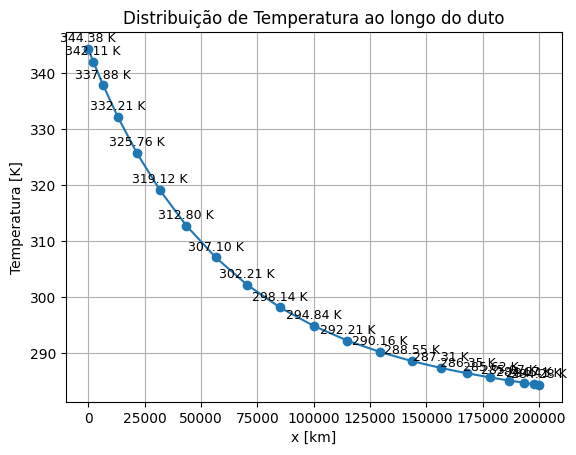

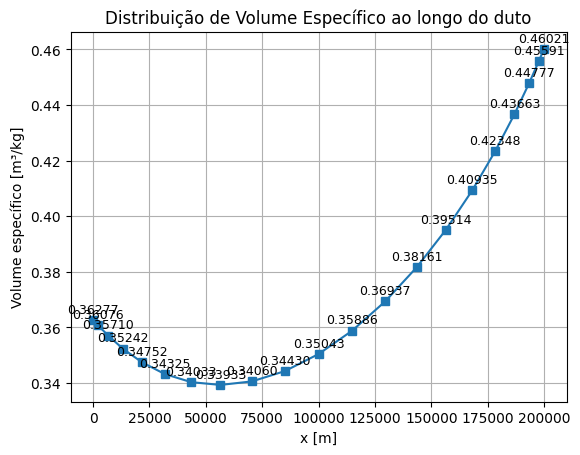

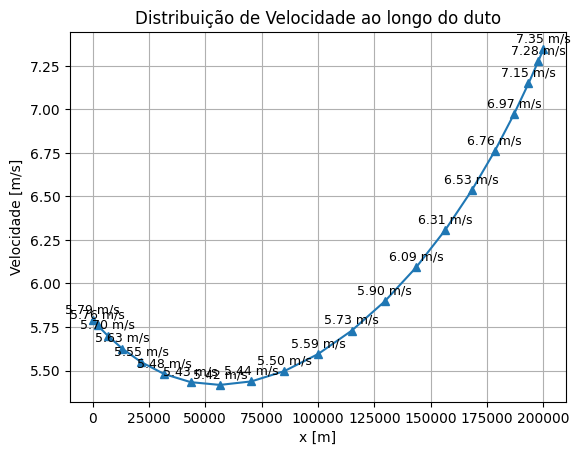

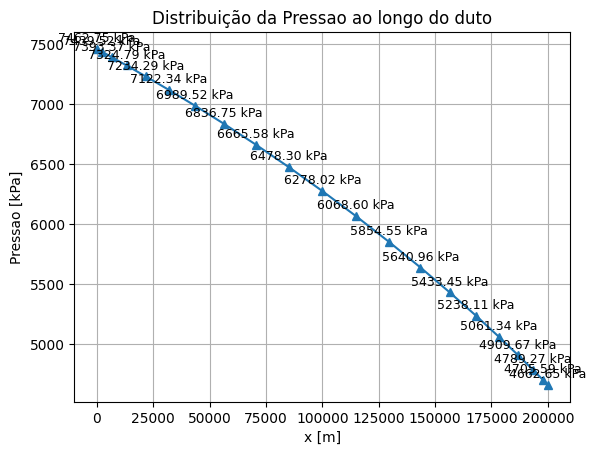

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# --- Temperatura (K) ---
plt.figure()
plt.plot(x_avaliar, T_sol_estc, marker='o', linestyle='-')
for xi, Ti in zip(x_avaliar, T_sol_estc):
    plt.annotate(f'{Ti:.2f} K', xy=(xi, Ti), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Temperatura ao longo do duto')
plt.xlabel('x [km]')
plt.ylabel('Temperatura [K]')
plt.grid(True)

# --- Volume específico (m³/kg) ---
plt.figure()
plt.plot(x_avaliar, V_sol_estc, marker='s', linestyle='-')
for xi, Vi in zip(x_avaliar, V_sol_estc):
    plt.annotate(f'{Vi:.5f}', xy=(xi, Vi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Volume Específico ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Volume específico [m³/kg]')
plt.grid(True)

# --- Velocidade (m/s) ---
plt.figure()
plt.plot(x_avaliar, w_sol_estc, marker='^', linestyle='-')
for xi, wi in zip(x_avaliar, w_sol_estc):
    plt.annotate(f'{wi:.2f} m/s', xy=(xi, wi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição de Velocidade ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Velocidade [m/s]')
plt.grid(True)


plt.figure()
plt.plot(x_avaliar, P_sol_estc, marker='^', linestyle='-')
for xi, Pi in zip(x_avaliar, P_sol_estc):
    plt.annotate(f'{Pi:.2f} kPa', xy=(xi, Pi), xytext=(0, 5), textcoords='offset points', ha='center', fontsize=9)
plt.title('Distribuição da Pressao ao longo do duto')
plt.xlabel('x [m]')
plt.ylabel('Pressao [kPa]')
plt.grid(True)

plt.show()


In [6]:
import random

def gerar_rotacoes(n=250, minimo=500, maximo=1000, passo_max=50):
    seq = []
    
    # começa em um valor aleatório dentro dos limites
    atual = random.randint(minimo, maximo)
    seq.append(atual)

    for _ in range(n - 1):
        # variação entre -50 e +50
        delta = random.randint(-passo_max, passo_max)
        proximo = atual + delta

        # limitar aos bounds
        proximo = max(minimo, min(maximo, proximo))

        seq.append(proximo)
        atual = proximo

    return seq


sequencia_rot = gerar_rotacoes()
print(sequencia_rot)

[551, 553, 529, 509, 500, 500, 536, 552, 564, 514, 531, 539, 500, 535, 549, 501, 500, 500, 500, 500, 535, 530, 549, 554, 541, 563, 606, 642, 685, 645, 663, 640, 656, 703, 675, 682, 680, 679, 677, 701, 689, 643, 601, 566, 575, 604, 579, 555, 553, 539, 518, 500, 529, 522, 557, 556, 594, 558, 603, 636, 655, 684, 670, 701, 746, 795, 792, 751, 720, 766, 815, 788, 794, 810, 791, 826, 777, 812, 855, 844, 836, 798, 763, 730, 764, 796, 827, 778, 785, 808, 820, 777, 738, 759, 768, 802, 816, 801, 782, 778, 775, 733, 773, 754, 765, 770, 780, 804, 816, 779, 757, 780, 742, 780, 814, 803, 827, 843, 862, 899, 933, 970, 929, 913, 942, 900, 889, 850, 811, 826, 855, 867, 867, 826, 789, 818, 771, 790, 818, 863, 871, 905, 871, 916, 944, 922, 931, 911, 888, 884, 899, 943, 904, 868, 880, 882, 905, 896, 914, 895, 918, 939, 989, 967, 920, 944, 971, 940, 951, 974, 997, 970, 992, 1000, 988, 952, 906, 887, 933, 935, 955, 955, 952, 986, 1000, 964, 983, 1000, 984, 949, 985, 1000, 954, 989, 1000, 1000, 1000, 1000, 9

In [7]:
# meu_sistema = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)
# # --- Condições iniciais ---
# T0 = T_sol_estc
# V0 = V_sol_estc
# w0 = w_sol_estc
# gas_temp = gas.copy_change_conditions(T_sol_estc[-1], None, V_sol_estc[-1], 'gas')
# y0 = np.empty(n_nodes * 3)
# y0[0::3] = T0
# y0[1::3] = V0
# y0[2::3] = w0
# z0 = z_sol + [rho * A * w_sol_estc[0], gas_temp.P]
# y0 = np.array(y0, dtype=float)
# z0 = np.array(z0, dtype=float)
# print(z0)
# u0 = np.array([700.0, 4000, 300.0, 2.1506])
# dt = 300
# # --- Simulação temporal ---
# n_steps = 1500 # número de passos
# t_sim = np.linspace(0, n_steps * dt, n_steps)
# y_sol = np.zeros((n_steps, len(y0)))

# sim = SimuladorDuto(meu_sistema)
# resultados = sim.run(y0, z0, u0, 250, 250, sequencia_rot, dt)
# sim.plotar()

In [8]:
# RNN_train, x_train, y_train, x_min, x_max, y_min, y_max = sim.train_dataset(6)


# N = x_train.shape[0]
# cut = int(0.7 * N)

# # Split sequencial (mantém a ordem temporal)
# x_train_split = x_train[:cut]
# y_train_split = y_train[:cut]

# x_val_split = x_train[cut:]
# y_val_split = y_train[cut:]

# print("Treino:", x_train_split.shape, y_train_split.shape)
# print("Validação:", x_val_split.shape, y_val_split.shape)

In [9]:
# torch.save({
#     "x_train": x_train,
#     "y_train": y_train,
#     "x_val": x_val_split,
#     "y_val": y_val_split,
#     "x_min": x_min,
#     "x_max": x_max,
#     "y_min": y_min,
#     "y_max": y_max
# }, "dataset.pt")

In [10]:
data = torch.load("dataset.pt")

x_train = data["x_train"]
y_train = data["y_train"]
x_val_split = data["x_val"]
y_val_split = data["y_val"]
x_min = data["x_min"]
x_max = data["x_max"]
y_min = data["y_min"]
y_max = data["y_max"]


N = x_train.shape[0]
cut = int(0.7 * N)

# Split sequencial (mantém a ordem temporal)
x_train_split = x_train[:cut]
y_train_split = y_train[:cut]

x_val_split = x_train[cut:]
y_val_split = y_train[cut:]

/tmp/ipykernel_208145/2627926203.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("dataset.pt")


In [11]:
def objective(trial):

    # ----- HYPERPARAMETROS A AJUSTAR PELO OPTUNA -----
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    hidden_dim = trial.suggest_int("hidden_dim", 16, 256)
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # ----- CRIA O MODELO -----
    model = RNNModelWrapper(
        input_dim=x_train.shape[-1],
        hidden_dim=hidden_dim,
        output_dim=y_train.shape[-1],
        num_layers=num_layers,
        x_min=x_min, x_max=x_max,
        y_min=y_min, y_max=y_max,
        lr=lr,
        device="cpu"
    )

    # ----- TREINO CURTO PARA AVALIAR -----
    model.train_model(x_train_split, y_train_split, epochs=500)  # rápido p/ Optuna

    # ----- AVALIAÇÃO  -----
    model.eval()
    with torch.no_grad():
        preds = model(x_val_split.float())  # garante float
        loss = torch.mean((preds - y_val_split.float())**2)  # tensor

    return float(loss)  # Retorna um float para o Optuna

In [12]:
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=50)

# print("Melhores hiperparâmetros:")
# print(study.best_trial.params)
# print("Loss mínima:", study.best_value)

In [13]:
print(x_train_split.shape)
print(y_train_split.shape)
print(x_val_split.shape)
print(y_val_split.shape)

torch.Size([43745, 6, 4])
torch.Size([43745, 3])
torch.Size([18749, 6, 4])
torch.Size([18749, 3])


In [72]:

from libs.model import *

model = RNNModelWrapper(
    input_dim=x_train.shape[-1],
    hidden_dim=100,
    output_dim=y_train.shape[-1],
    num_layers= 1,
    x_min=x_min, x_max=x_max,
    y_min=y_min, y_max=y_max,
    lr=0.00028912058475362396,
    device="cpu"
)
x_train_norm = model.normalize_x(torch.tensor(x_train_split, dtype=torch.float32))
y_train_norm = model.normalize_y(torch.tensor(y_train_split, dtype=torch.float32))
x_train_norm = x_train_norm.view(-1, x_train_norm.size(-2), x_train_norm.size(-1))
# y_train_norm: [N, n_outputs]
y_train_norm = y_train_norm.view(-1, y_train_norm.size(-1))

train_dataset = TensorDataset(x_train_norm, y_train_norm)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

model.train_model(train_loader, epochs=500)

/home/matheusmarinho/Documentos/IC/Research_about_PINNs/Duto_Rede_de_gas/PSE_NE_2025/libs/model.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_min = torch.tensor(x_min, dtype=torch.float32).to(device)
/home/matheusmarinho/Documentos/IC/Research_about_PINNs/Duto_Rede_de_gas/PSE_NE_2025/libs/model.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_max = torch.tensor(x_max, dtype=torch.float32).to(device)
/tmp/ipykernel_208145/86543029.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train_norm = model.normalize_x

Epoch 10/500 | Loss = 0.000830
Epoch 20/500 | Loss = 0.000554
Epoch 30/500 | Loss = 0.000526
Epoch 40/500 | Loss = 0.000513
Epoch 50/500 | Loss = 0.000512
Epoch 60/500 | Loss = 0.000515
Epoch 70/500 | Loss = 0.000513
Epoch 80/500 | Loss = 0.000509
Epoch 90/500 | Loss = 0.000504
Epoch 100/500 | Loss = 0.000505
Epoch 110/500 | Loss = 0.000504
Epoch 120/500 | Loss = 0.000504
Epoch 130/500 | Loss = 0.000501
Epoch 140/500 | Loss = 0.000504
Epoch 150/500 | Loss = 0.000504
Epoch 160/500 | Loss = 0.000499
Epoch 170/500 | Loss = 0.000503
Epoch 180/500 | Loss = 0.000500
Epoch 190/500 | Loss = 0.000497
Epoch 200/500 | Loss = 0.000498
Epoch 210/500 | Loss = 0.000497
Epoch 220/500 | Loss = 0.000497
Epoch 230/500 | Loss = 0.000497
Epoch 240/500 | Loss = 0.000500
Epoch 250/500 | Loss = 0.000495
Epoch 260/500 | Loss = 0.000495
Epoch 270/500 | Loss = 0.000496
Epoch 280/500 | Loss = 0.000500
Epoch 290/500 | Loss = 0.000493
Epoch 300/500 | Loss = 0.000493
Epoch 310/500 | Loss = 0.000500
Epoch 320/500 | L

In [81]:
torch.save(model, "modelo_completo.pth")

/tmp/ipykernel_208145/3976455918.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor = torch.tensor(x_val_split, dtype=torch.float32).to(model.device)


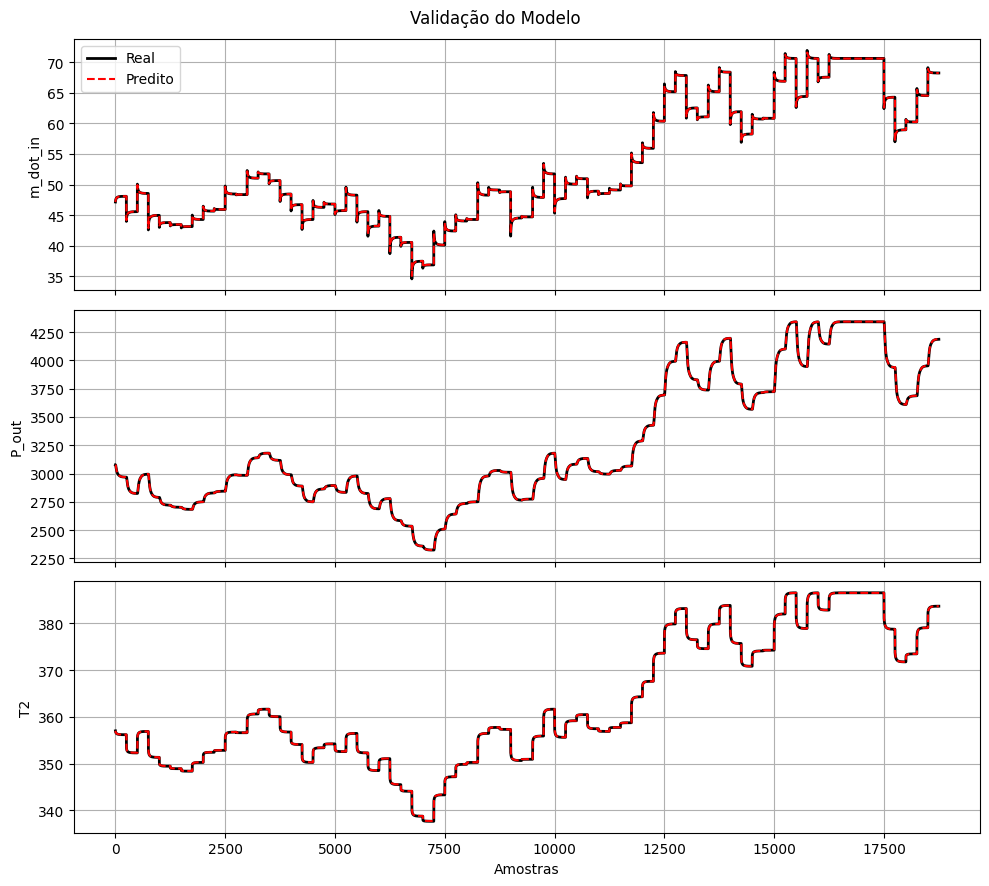

In [73]:
def plot_outputs(y_true, y_pred, labels=None, title="Validação do Modelo"):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Squeeze para remover dimensões extras
    y_true = np.squeeze(y_true)
    y_pred = np.squeeze(y_pred)

    # Garantir que ambos tenham o mesmo número de colunas
    assert y_true.shape[1] == y_pred.shape[1], "y_true e y_pred têm número diferente de variáveis"

    n_vars = y_true.shape[1]

    if labels is None:
        labels = [f"Var {i+1}" for i in range(n_vars)]

    fig, axs = plt.subplots(n_vars, 1, figsize=(10, 3*n_vars), sharex=True)

    # Se houver apenas uma variável, axs não é lista
    if n_vars == 1:
        axs = [axs]

    for i in range(n_vars):
        axs[i].plot(y_true[:, i], 'black', label="Real", linewidth=2)
        axs[i].plot(y_pred[:, i], 'red', label="Predito", linestyle="--")
        axs[i].set_ylabel(labels[i])
        axs[i].grid(True)

    axs[-1].set_xlabel("Amostras")
    fig.suptitle(title)
    axs[0].legend()  # só uma legenda no topo
    plt.tight_layout()
    plt.show()



# x_val_split: [n_samples, seq_len, n_features]
x_val_tensor = torch.tensor(x_val_split, dtype=torch.float32).to(model.device)

# Normalizar x
x_val_norm = 2 * (x_val_tensor - model.x_min) / (model.x_max - model.x_min) - 1

# Forward da RNN
model.eval()
with torch.no_grad():
    out, _ = model.rnn(x_val_norm)
    last_out = out[:, -1, :]         
    y_pred_norm = model.fc(last_out) 

# Denormalizar y
y_pred = (y_pred_norm + 1) * 0.5 * (model.y_max.unsqueeze(0) - model.y_min.unsqueeze(0)) + model.y_min.unsqueeze(0)

# Passar para numpy
y_pred = y_pred.cpu().numpy()

# Plotar resultados
plot_outputs(y_val_split, y_pred, labels=["m_dot_in", "P_out", "T2"])

In [76]:
meu_sistema = duto_casadi(gas, visc, compressor=compressor, Lc=200000.0, D=0.42)
# --- Condições iniciais ---
T0 = T_sol_estc
V0 = V_sol_estc
w0 = w_sol_estc
gas_temp = gas.copy_change_conditions(T_sol_estc[-1], None, V_sol_estc[-1], 'gas')
y0 = np.empty(n_nodes * 3)
y0[0::3] = T0
y0[1::3] = V0
y0[2::3] = w0
z0 = z_sol + [rho * A * w_sol_estc[0], gas_temp.P]
y0 = np.array(y0, dtype=float)
z0 = np.array(z0, dtype=float)
print(z0)
u0 = np.array([700.0, 4000, 300.0, 2.1506])
dt = 300
# --- Simulação temporal ---
n_steps = 1500 # número de passos
t_sim = np.linspace(0, n_steps * dt, n_steps)
y_sol = np.zeros((n_steps, len(y0)))

sequencia_rot = gerar_rotacoes(n = 50)
sim = SimuladorDuto(meu_sistema)
resultados = sim.run(y0, z0, u0, 50, 300, sequencia_rot, dt)

[3.20961332e+02 4.83330443e-01 3.20358516e+02 4.95116834e-01
 3.38895396e+02 3.55065191e-01 3.44383570e+02 3.62770977e-01
 5.83790379e-01 3.60000000e+01 4.66265075e+03]


In [77]:
RNN_train_2, x_train_2, y_train_2, x_min_2, x_max_2, y_min_2, y_max_2 = sim.train_dataset(6)
N = x_train_2.shape[0]
cut = int(0.7 * N)

# Split sequencial (mantém a ordem temporal)
x_train_split_2 = x_train_2[:cut]
y_train_split_2 = y_train_2[:cut]

x_val_split_2 = x_train_2[cut:]
y_val_split_2 = y_train_2[cut:]
x_val_tensor_2 = torch.tensor(x_val_split_2, dtype=torch.float32).to(model.device)

x_val_norm_2 = 2 * (x_val_tensor_2 - x_min) / (x_max - x_min) - 1

/tmp/ipykernel_208145/3241633743.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_val_tensor_2 = torch.tensor(x_val_split_2, dtype=torch.float32).to(model.device)


In [78]:
def test_model(model, x_test, interval):
    model.eval()
    m_dot_in = [
        x_test[0, 0, 0].item(),
        x_test[0, 1, 0].item(),
        x_test[0, 2, 0].item(),
        x_test[0, 3, 0].item(),
        x_test[0, 4, 0].item(),
        x_test[0, 5, 0].item(),
    ]
    
    P_out = [
        x_test[0, 0, 1].item(),
        x_test[0, 1, 1].item(),
        x_test[0, 2, 1].item(),
        x_test[0, 3, 1].item(),
        x_test[0, 4, 1].item(),
        x_test[0, 5, 1].item(),
    ]
    
    T_in = [
        x_test[0, 0, 2].item(),
        x_test[0, 1, 2].item(),
        x_test[0, 2, 2].item(),
        x_test[0, 3, 2].item(),
        x_test[0, 4, 2].item(),
        x_test[0, 5, 2].item(),
    ]
    
    
    input_tensor = torch.zeros((1, 6, 4), dtype=torch.float32)

    for i in range(len(interval)):
        input_tensor[0, :, 0] = torch.tensor(m_dot_in[-6:])
        input_tensor[0, :, 1] = torch.tensor(P_out[-6:])
        input_tensor[0, :, 2] = torch.tensor(T_in[-6:])
        input_tensor[0, :, 3] = x_test[i, :, 3]
        with torch.no_grad():
            out, _ = model.rnn(input_tensor)
            last_out = out[:, -1, :]         # pegar apenas o último timestep
            prediction100 = model.fc(last_out)
        m_dot_in.append(prediction100[0, 0].item())
        P_out.append(prediction100[0, 1].item())
        T_in.append(prediction100[0, 2].item())
    return m_dot_in, P_out, T_in

In [79]:
interval = range(3000)
m_dot_in, P_out, T_in = test_model(model,  x_val_norm_2, interval)

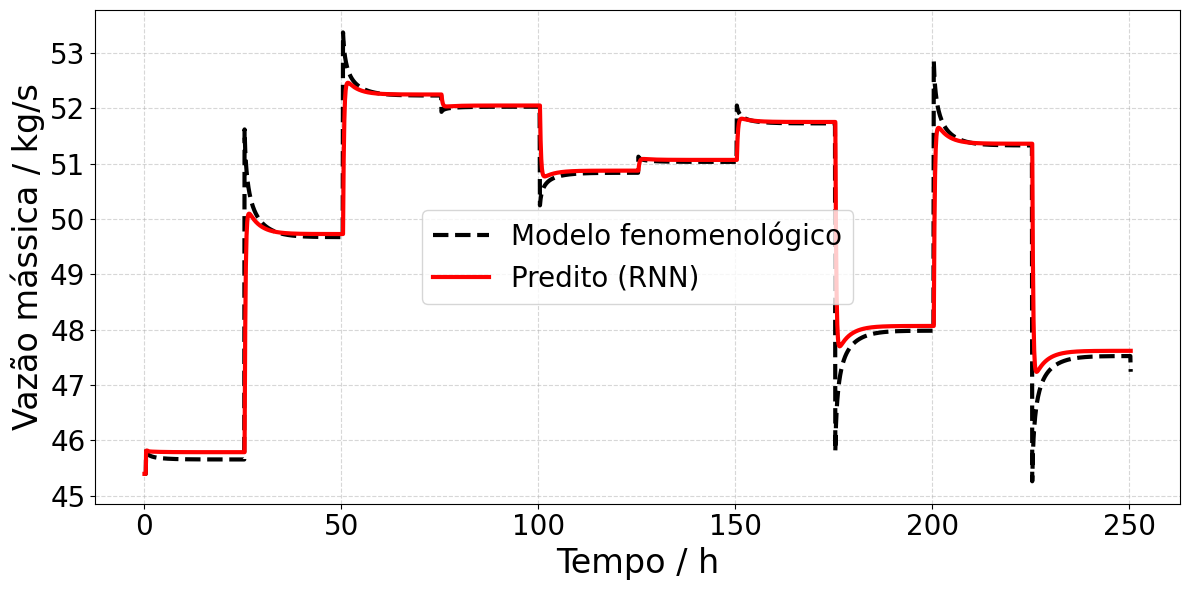

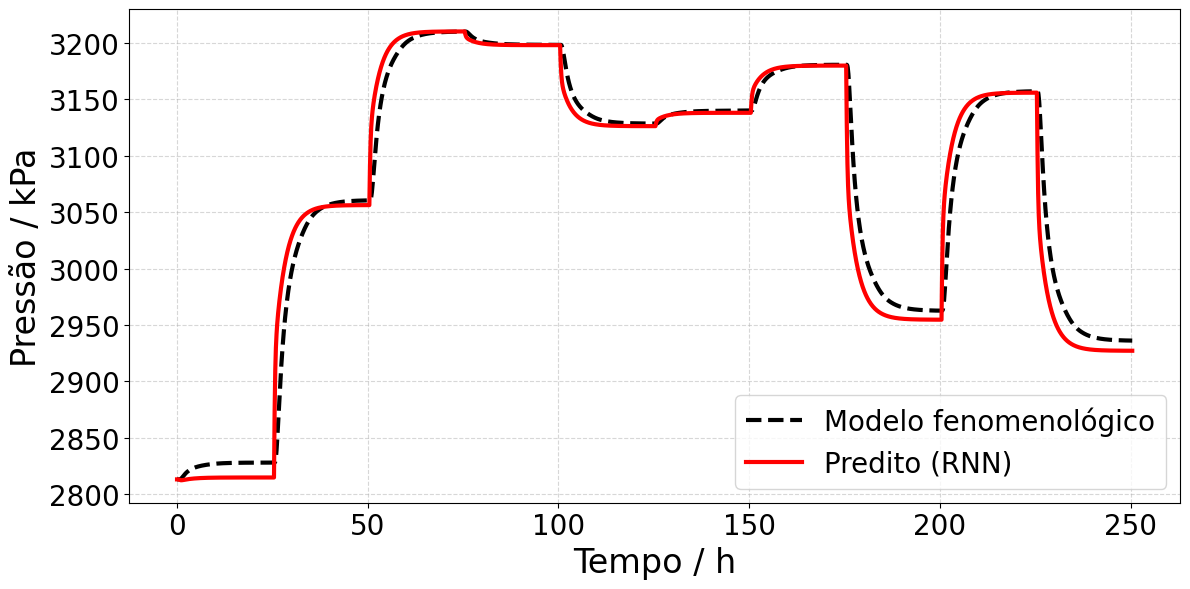

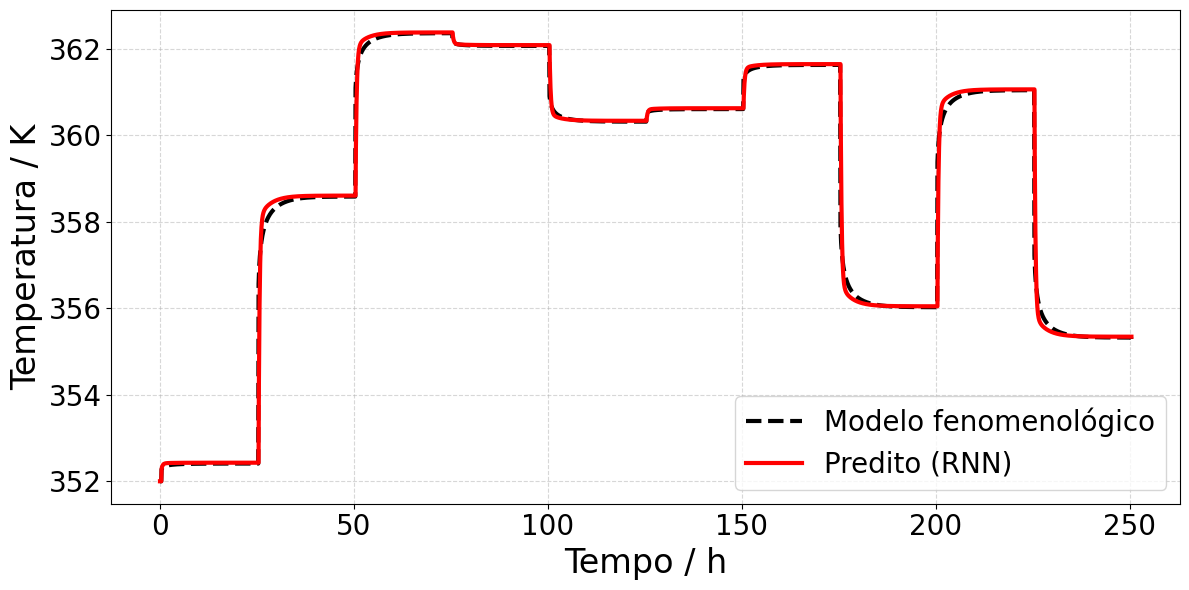

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Converte listas em numpy
pred_m = np.array(m_dot_in)
pred_P = np.array(P_out)
pred_T = np.array(T_in)

# Pega limites
y_min = np.array(model.y_min)
y_max = np.array(model.y_max)

# Desnormaliza
pred_m = (pred_m + 1) * 0.5 * (y_max.squeeze(0)[0] - y_min.squeeze(0)[0]) + y_min.squeeze(0)[0]
pred_P = (pred_P + 1) * 0.5 * (y_max.squeeze(0)[1] - y_min.squeeze(0)[1]) + y_min.squeeze(0)[1]
pred_T = (pred_T + 1) * 0.5 * (y_max.squeeze(0)[2] - y_min.squeeze(0)[2]) + y_min.squeeze(0)[2]

# Valores reais
real_m = x_val_split_2[:len(pred_m), 0, 0].cpu().numpy()
real_P = x_val_split_2[:len(pred_P), 0, 1].cpu().numpy()
real_T = x_val_split_2[:len(pred_T), 0, 2].cpu().numpy()

# Tempo em horas
dt = 300  # segundos
time = np.arange(len(pred_m)) * dt / 3600  # converte para horas

# Função para plot
def plot_comparison(time, real, pred, ylabel):
    plt.figure(figsize=(12,6))
    plt.plot(time, real, 'k--', linewidth=3, label="Modelo fenomenológico")  # tracejado preto mais grosso
    plt.plot(time, pred, 'r', linewidth=3, label="Predito (RNN)")            # vermelho sólido mais grosso
    plt.xlabel("Tempo / h", fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend(fontsize=20)
    plt.tight_layout()
    plt.show()

# Plota cada variável
plot_comparison(time, real_m, pred_m, "Vazão mássica / kg/s")
plot_comparison(time, real_P, pred_P, "Pressão / kPa")
plot_comparison(time, real_T, pred_T, "Temperatura / K")